In [1]:
import pandas as pd
from scipy.stats import linregress
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scgenome import cncluster
from scdna_replication_tools.plot_utils import get_clone_cmap, plot_colorbar, plot_clustered_cell_cn_matrix, get_signals_cmap

In [2]:
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

despine_offset = 5
despine_trim = True

In [3]:
def merge_sample_rt_and_bafs(sample_mean_rt, sample_bafs):
    ''' Query and pivot the dataframes such that each row has both the chrX relative RT and BAFs for a given sample '''
    # subset df to just chr=='X'
    sample_df = sample_bafs.query('chr=="X"')[['patient', 'chr_arm', 'dna_baf_mean', 'rna_baf_mean', 'dna_baf_std', 'rna_baf_std']]
    # pivot such that chrXp_dna_baf, chrXq_dna_baf, chrXp_rna_baf, chrXq_rna_baf are columns
    sample_df = sample_df.pivot(index='patient', columns='chr_arm', values=['dna_baf_mean', 'rna_baf_mean', 'dna_baf_std', 'rna_baf_std'])
    # flatten the column names
    sample_df.columns = ['_'.join(col).strip() for col in sample_df.columns.values]
    # reset the index
    sample_df = sample_df.reset_index().rename(columns={'patient': 'dataset'})
    # merge sample_df with sample_mean_rt
    sample_df = pd.merge(sample_df, sample_mean_rt)

    return sample_df


def merge_sample_mapping(sample_df):
    # create a mapping of sample_id to cell/tumor type, condition, and signature
    sample_id_to_type = {
        'SA1047': 'HGSOC',
        'SA1049': 'HGSOC',
        'SA1050': 'HGSOC',
        'SA1051': 'HGSOC',
        'SA1052': 'HGSOC',
        'SA1053': 'HGSOC',
        'SA1091': 'HGSOC',
        'SA1093': 'HGSOC',
        'SA1096': 'HGSOC',
        'SA1162': 'HGSOC',
        'SA1181': 'HGSOC',
        'SA1182': 'HGSOC',
        'SA1184': 'HGSOC',
        'SA501': 'TNBC',
        'SA530': 'TNBC',
        'SA604': 'TNBC',
        'SA039': 'hTERT',
        'SA906a': 'hTERT',
        'SA906b': 'hTERT',
        'SA1188': 'hTERT',
        'SA1292': 'hTERT',
        'SA1054': 'hTERT',
        'SA1055': 'hTERT',
        'SA1056': 'hTERT',
        'OV2295': 'OV2295',
        'SA535': 'TNBC',
        'SA609': 'TNBC',
        'SA1035': 'TNBC',
        'T47D': 'T47D',
        'GM18507': 'GM18507'
    }
    sample_id_to_condition = {
        'SA1047': 'PDX',
        'SA1049': 'PDX',
        'SA1050': 'PDX',
        'SA1051': 'PDX',
        'SA1052': 'PDX',
        'SA1053': 'PDX',
        'SA1091': 'PDX',
        'SA1093': 'PDX',
        'SA1096': 'PDX',
        'SA1162': 'PDX',
        'SA1181': 'PDX',
        'SA1182': 'PDX',
        'SA1184': 'PDX',
        'SA501': 'PDX',
        'SA530': 'PDX',
        'SA604': 'PDX',
        'SA039': 'Line',
        'SA906a': 'Line',
        'SA906b': 'Line',
        'SA1188': 'Line',
        'SA1292': 'Line',
        'SA1054': 'Line',
        'SA1055': 'Line',
        'SA1056': 'Line',
        'OV2295': 'Line',
        'SA535': 'PDX',
        'SA609': 'PDX',
        'SA1035': 'PDX',
        'T47D': 'Line',
        'GM18507': 'Line'
    }
    sample_id_to_signature = {
        'SA1047': 'TD',
        'SA1049': 'FBI',
        'SA1050': 'HRD-Dup',
        'SA1051': 'HRD-Dup',
        'SA1052': 'HRD-Dup',
        'SA1053': 'HRD-Dup',
        'SA1091': 'FBI',
        'SA1093': 'TD',
        'SA1096': 'FBI',
        'SA1162': 'FBI',
        'SA1181': 'HRD-Dup',
        'SA1182': 'FBI',
        'SA1184': 'HRD-Dup',
        'SA501': 'HRD-Dup',
        'SA530': 'FBI',
        'SA604': 'FBI',
        'SA039': 'N/A',
        'SA906a': 'N/A',
        'SA906b': 'N/A',
        'SA1188': 'N/A',
        'SA1292': 'N/A',
        'SA1054': 'N/A',
        'SA1055': 'N/A',
        'SA1056': 'N/A',
        'OV2295': 'N/A',
        'SA535': 'HRD-Dup',
        'SA609': 'FBI',
        'SA1035': 'N/A',
        'T47D': 'N/A',
        'GM18507': 'N/A'
    }

    sample_mapping = pd.DataFrame(sample_id_to_condition.items(), columns=['dataset', 'condition'])
    sample_mapping['type'] = sample_mapping['dataset'].map(sample_id_to_type)
    sample_mapping['signature'] = sample_mapping['dataset'].map(sample_id_to_signature)
    
    # merge sample_df with sample_mapping
    sample_df = pd.merge(sample_df, sample_mapping)

    return sample_df, sample_mapping


In [4]:
def get_type_cmap():
    cmap = {
        'hTERT': 'C0',
        'OV2295': 'C1',
        'TNBC': 'C2',
        'HGSOC': 'C3'
    }
    return cmap

cell_type_cdict = {
    'hTERT': 'lightsteelblue', 0: 'lightsteelblue',
    'HGSOC': 'teal', 1: 'teal',
    'TNBC': 'salmon', 2: 'salmon',
    'OV2295': 'lightgreen', 3: 'lightgreen',
    'T47D': 'orchid', 4: 'orchid',
    'GM18507': 'khaki', 5: 'khaki',
}
cell_type_cmap = LinearSegmentedColormap.from_list('cell_type_cmap', list(cell_type_cdict.values()), N=len(cell_type_cdict))

signature_cdict = {
    'FBI': 'plum', 0: 'plum',
    'HRD': 'cyan', 1: 'cyan',
    'TD': 'coral', 2: 'coral',
}
signature_cmap = LinearSegmentedColormap.from_list('signature_cmap', list(signature_cdict.values()), N=len(signature_cdict))

condition_cdict = {
    'Line': 'tan', 0: 'tan',
    'PDX': 'lightskyblue', 1: 'lightskyblue',
}
condition_cmap = LinearSegmentedColormap.from_list('condition_cmap', list(condition_cdict.values()), N=len(condition_cdict))

ploidy_cdict = {2:'#CCCCCC', 3:'#FDCC8A', 4:'#FC8D59', 5:'#E34A33'}
ploidy_cmap = LinearSegmentedColormap.from_list('ploidy_cmap', list(ploidy_cdict.values()), N=len(ploidy_cdict))

In [5]:
def plot_hTERT_sample_bafs_vs_rt(sample_df, ax):
    # plot the hTERT samples
    sns.regplot(y='mean_chrX_rt_delay', x='dna_baf_mean_Xf', data=sample_df.query('type=="hTERT"'), ax=ax, ci=None, color=cell_type_cdict['hTERT'])
    ax.set_ylabel('chrX relative RT\n<--delayed | advanced -->')
    ax.set_xlabel('chrX DNA BAF')
    ax.set_title('hTERT samples')
    # add r and p-value annotations in the bottom-left corner
    reg = linregress(sample_df.query('type=="hTERT"')['dna_baf_mean_Xf'].values, sample_df.query('type=="hTERT"')['mean_chrX_rt_delay'].values)
    ax.text(0.05, 0.05, 'r={:.2f}\np={:.2e}'.format(reg.rvalue, reg.pvalue), transform=ax.transAxes)
    # edit the x-and y-axis limits to give 0.05 padding on all sides compared to the current limits
    ax.set_xlim([ax.get_xlim()[0] - 0.05, ax.get_xlim()[1] + 0.05])
    ax.set_ylim([max(-.4, ax.get_ylim()[0] - 0.05), ax.get_ylim()[1] + 0.05])
    sns.despine(ax=ax, offset=despine_offset, trim=despine_trim)


def plot_SA1054_subclonal_bafs_vs_rt(clone_df, ax):
    # scatterplot of the data
    sns.scatterplot(y='mean_chrX_rt_delay', x='dna_chrX_baf_mean', hue='clone_id', data=clone_df.query('dataset=="SA1054"'), ax=ax, size='num_cells_s', sizes=(10, 100), palette=get_clone_cmap())

    sns.regplot(y='mean_chrX_rt_delay', x='dna_chrX_baf_mean', data=clone_df.query('dataset=="SA1054"'), scatter=False, ax=ax, color='grey')

    # fit a linear regression model to the data
    res = linregress(clone_df.query('dataset=="SA1054"')['dna_chrX_baf_mean'].values, clone_df.query('dataset=="SA1054"')['mean_chrX_rt_delay'].values)
    # add r- and p-value annotations in the bottom-left corner
    ax.text(0.05, 0.05, 'r={:.2f}\np={:.2e}'.format(res.rvalue, res.pvalue), transform=ax.transAxes)

    # edit the x-and y-axis limits to give 0.05 padding on all sides compared to the current limits
    ax.set_xlim([ax.get_xlim()[0] - 0.05, ax.get_xlim()[1] + 0.05])
    ax.set_ylim([ax.get_ylim()[0] - 0.05, ax.get_ylim()[1] + 0.05])

    ax.set_ylabel('chrX relative RT\n<--delayed | advanced-->')
    ax.set_xlabel('chrX DNA BAF')
    ax.set_title('SA1054 clones')

    # add the legend to the right of the plot
    # remove clone_id elements from the legend
    handles, labels = ax.get_legend_handles_labels()
    # subset handles and labels to just the 7th and final elements
    handles = [handles[7], handles[-1]]
    labels = [labels[7].split('.')[0], labels[-1].split('.')[0]]
    ax.legend(handles, labels, loc='upper right', title='# S cells')

    sns.despine(ax=ax, offset=despine_offset, trim=despine_trim)


def plot_sample_rt_delays(sample_df, ax):
    # make a barplot of 'mean_chrX_rt_delay' on the y-axis and 'dataset' on the x-axis with the bars colored by 'type'
    sns.barplot(y='mean_chrX_rt_delay', x='dataset', hue='type', data=sample_df.sort_values(by=['type', 'dataset']), ax=ax, palette=cell_type_cdict)
    ax.set_ylabel('chrX relative RT\n<--delayed | advanced -->')
    ax.set_xlabel('')
    ax.set_title('Breast & ovarian samples')
    # add the legend to the bottom left of the plot
    ax.legend(loc='lower left', ncol=2)
    sns.despine(ax=ax, offset=despine_offset, trim=despine_trim)
    # rotate the x-tick labels by 45 degrees
    ax.tick_params(axis='x', rotation=45)


def plot_all_sample_bafs_vs_rt(sample_df, ax):
    ''' Scatterplot of all samples with chrX DNA BAF on the x-axis and chrX relative RT on the y-axis '''
    # the regression plot should not include the data points
    sns.scatterplot(y='mean_chrX_rt_delay', x='dna_baf_mean_Xf', hue='type', data=sample_df, ax=ax, palette=cell_type_cdict, legend=False)
    sns.regplot(y='mean_chrX_rt_delay', x='dna_baf_mean_Xf', data=sample_df, scatter=False, ax=ax, color='grey')
    ax.set_ylabel('chrX relative RT\n<--delayed | advanced -->')
    ax.set_xlabel('chrX DNA BAF')
    # add r and p-value annotations in the bottom-left corner
    reg = linregress(sample_df['dna_baf_mean_Xf'].values, sample_df['mean_chrX_rt_delay'].values)
    ax.text(0.05, 0.05, 'r={:.2f}\np={:.2e}'.format(reg.rvalue, reg.pvalue), transform=ax.transAxes)
    # edit the x-and y-axis limits to give 0.05 padding on all sides compared to the current limits
    ax.set_xlim([ax.get_xlim()[0] - 0.05, ax.get_xlim()[1] + 0.05])
    ax.set_ylim([ax.get_ylim()[0] - 0.05, ax.get_ylim()[1] + 0.05])
    sns.despine(ax=ax, offset=despine_offset, trim=despine_trim)


def plot_transcription_gap_vs_rt(sample_df, ax):
    ''' Plot the chrX relative RT on the y-axis and the chrX transcription gap (DNA BAF - RNA BAF) on the x-axis '''
    # the regression plot should not include the data points
    sns.scatterplot(y='mean_chrX_rt_delay', x='BAF_gap', hue='type', data=sample_df, ax=ax, palette=cell_type_cdict, legend=False)
    sns.regplot(y='mean_chrX_rt_delay', x='BAF_gap', data=sample_df, scatter=False, ax=ax, color='grey')
    ax.set_ylabel('chrX relative RT\n<--delayed | advanced -->')
    ax.set_xlabel('chrX transcription gap\n<--lower RNA BAF | higher RNA BAF -->')
    # add r and p-value annotations in the bottom-left corner
    reg = linregress(sample_df.dropna()['BAF_gap'].values, sample_df.dropna()['mean_chrX_rt_delay'].values)
    ax.text(0.05, 0.80, 'r={:.2f}\np={:.2e}'.format(reg.rvalue, reg.pvalue), transform=ax.transAxes)
    # edit the x-and y-axis limits to give 0.05 padding on all sides compared to the current limits
    ax.set_xlim([ax.get_xlim()[0] - 0.05, ax.get_xlim()[1] + 0.05])
    ax.set_ylim([ax.get_ylim()[0] - 0.05, ax.get_ylim()[1] + 0.05])
    sns.despine(ax=ax, offset=despine_offset, trim=despine_trim)


def plot_Xq_loh_rt_delays(sample_df, ax, Xq_loh_samples):
    ''' Barplot of Xp relative RTs for samples with Xq LOH but balanced Xp '''
    sample_df_Xq_loh = sample_df.loc[sample_df['dataset'].isin(Xq_loh_samples)]
    sns.barplot(y='mean_chrXp_rt_delay', x='dataset', hue='type', data=sample_df_Xq_loh.sort_values(by=['type', 'dataset']), ax=ax, palette=cell_type_cdict)
    
    # add a horizontal line at the mean relative RT for SA039 (balanced across all of chrX)
    ax.axhline(sample_df.query('dataset=="SA039"')['mean_chrXp_rt_delay'].values[0], color='grey', linestyle='--', label='SA039')
    
    ax.set_ylabel('chrXp relative RT\n<--delayed | advanced -->')
    ax.set_xlabel(None)
    ax.set_title('Samples with Xq LOH but not Xp LOH')
    # rotate the x-tick labels by 45 degrees
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='center')
    # show the legend on the bottom left of the plot
    ax.legend(loc='lower left')
    sns.despine(ax=ax, offset=despine_offset, trim=despine_trim)


def plot_Xq_loh_bafs(sample_df, sample_bafs, ax, Xq_loh_samples):
    ''' Scatterplot of DNA vs RNA BAFs for all chromosome arms for samples with Xq LOH but balanced Xp '''
    # loop through all samples with Xq LOH but balanced Xp
    for s in Xq_loh_samples:
        # plot all the autosomes with grey points
        sns.scatterplot(data=sample_bafs.query('patient==@s').query('chr_type=="autosome"'), x='dna_baf_mean', y='rna_baf_mean', color='grey', alpha=0.1, ax=ax)
        # plot all of chrX with points colored by chrX arm and the marker shape indicating the sample
        sns.scatterplot(x='dna_baf_mean_Xp', y='rna_baf_mean_Xp', data=sample_df.query('dataset==@s'), color='C4', label='Xp', ax=ax)
        sns.scatterplot(x='dna_baf_mean_Xq', y='rna_baf_mean_Xq', data=sample_df.query('dataset==@s'), color='C5', label='Xq', ax=ax)
    ax.set_xlabel('Arm DNA BAF')
    ax.set_ylabel('Arm RNA BAF')
    ax.set_title('Samples with Xq LOH but not Xp LOH')
    # edit the legend to only take the first two elements and display in the top-left corner
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], loc='upper left')
    # add a dashed grey line at y=x
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    sns.despine(ax=ax, offset=despine_offset, trim=despine_trim)

In [6]:
def plot_cn_and_signals_states(
    df, ax_hmm, ax_sig, ax_clone,
    cn_col='state', signals_col='state_phase', secondary_sort_col='frac_rt',
    clone_col='clone_id', clone_cmap=get_clone_cmap(), sig_cmap=get_signals_cmap(),
    chrom_boundary_width=0.5, chromosome=None
    ):
    """ 
    Plot 3 heatmaps for S-phase cells: hmmcopy state, inferred CN state, inferred rep state
    All rows should be sorted first by clone_id and then by frac_rt. The colorbars should be on the far left.
    """
    # create mapping of clones to cluster ids
    cluster_col = 'cluster_id'
    clone_dict = dict([(y,x+1) for x,y in enumerate(sorted(df[clone_col].unique()))])
    df[cluster_col] = df[clone_col]
    df = df.replace({cluster_col: clone_dict})

    # left: hmmcopy states
    plot_data0 = plot_clustered_cell_cn_matrix(
        ax_hmm, df, cn_col, cluster_field_name=cluster_col, secondary_field_name=secondary_sort_col, 
        chrom_boundary_width=chrom_boundary_width, chromosome=chromosome
    )

    # right: signals allelic states
    plot_data1 = plot_clustered_cell_cn_matrix(
        ax_sig, df, signals_col, cluster_field_name=cluster_col, secondary_field_name=secondary_sort_col, 
        cmap=sig_cmap, chrom_boundary_width=chrom_boundary_width, chromosome=chromosome, max_cn=None
    )

    # hide the y-ticks and labels for all heatmaps
    for ax in [ax_hmm, ax_sig, ax_clone]:
        ax.set_yticks([])
        ax.set_yticklabels([])
    
    if len(clone_dict) > 1:
        # annotate the clones
        cell_ids = plot_data0.columns.get_level_values(0).values
        cluster_ids0 = plot_data0.columns.get_level_values(1).values
        # use mcolors to change every element in the dict to rgba
        for key in clone_cmap.keys():
            clone_cmap[key] = mcolors.to_rgba(clone_cmap[key])
        color_mat, _ = cncluster.get_cluster_colors(cluster_ids0, color_map=clone_cmap, return_map=True)

        # get list of color pigments in the same order as clone_dict
        colors_used = []
        for c in color_mat:
            if c not in colors_used:
                colors_used.append(c)

        # match clone IDs to color pigments
        clones_to_colors = {}
        for i, key in enumerate(clone_dict.keys()):
            clones_to_colors[key] = colors_used[i]

        # create color bar that shows clone id for each row in heatmap
        plot_colorbar(ax_clone, color_mat)

        # add the titles and axes labels
        ax_clone.set_xticks([0.0])
        ax_clone.set_xticklabels(['clone'], rotation=90)
    
    return plot_data0

In [7]:
# load the signals data for SA1054
signals_SA1054 = pd.read_csv('scdna_replication_paper/analysis/schnapps-results/persample/SA1054_hscn.csv.gz')
signals_SA1054['chr'] = signals_SA1054['chr'].astype(str).astype('category')

clones_SA1054 = pd.read_csv('scdna_replication_paper/data/signatures/clone_trees/SA1054_clones.tsv', sep='\t')
clones_SA1054 = clones_SA1054.query('clone_id!="None"')

df_SA1054 = pd.merge(signals_SA1054, clones_SA1054, on='cell_id')

# create a second cell_id column that we can use to sort cells alphabetically within the same clone
df_SA1054_ordering = df_SA1054[['cell_id']].drop_duplicates().reset_index(drop=True).reset_index(drop=False).rename(columns={'index': 'cell_id_int'})
df_SA1054 = pd.merge(df_SA1054, df_SA1054_ordering)

# remap signals phases to integer states
signals_state_phase_to_int = {
    'A-Hom': -2,
    'A-Gained': -1,
    'Balanced': 0,
    'B-Gained': 1,
    'B-Hom': 2,
}
df_SA1054['state_phase_int'] = df_SA1054['state_phase'].apply(lambda x: signals_state_phase_to_int[x])

signals_SA1054.head()

,patient,cell_id,chr,start,end,state,copy,state_AS_phased,alleleA,alleleB,totalcounts,BAF,state_min,Maj,Min,LOH,phase,state_phase,state_BAF
0,SA1054,SA1054-A95632A-R04-C10,1,1,500000,4,NaN,2|2,NaN,NaN,NaN,NaN,2,2,2,NO,Balanced,Balanced,0.5
1,SA1054,SA1054-A95632A-R04-C10,1,500001,1000000,4,NaN,2|2,NaN,NaN,NaN,NaN,2,2,2,NO,Balanced,Balanced,0.5
2,SA1054,SA1054-A95632A-R04-C10,1,1000001,1500000,4,4.103268,2|2,NaN,NaN,NaN,NaN,2,2,2,NO,Balanced,Balanced,0.5
3,SA1054,SA1054-A95632A-R04-C10,1,1500001,2000000,4,3.736161,2|2,NaN,NaN,NaN,NaN,2,2,2,NO,Balanced,Balanced,0.5
4,SA1054,SA1054-A95632A-R04-C10,1,2000001,2500000,4,3.894378,2|2,4.0,3.0,7.0,0.428571,2,2,2,NO,Balanced,Balanced,0.5


In [8]:
sample_bafs = pd.read_csv('scdna_replication_paper/analysis/chrX/sample_arm_bafs.csv.gz')
clone_bafs = pd.read_csv('scdna_replication_paper/analysis/chrX/clone_arm_bafs.csv.gz')
sample_mean_rt = pd.read_csv('scdna_replication_paper/analysis/chrX/sample_rt.csv.gz')
clone_mean_rt = pd.read_csv('scdna_replication_paper/analysis/chrX/clone_rt.csv.gz')
counts = pd.read_csv('scdna_replication_paper/analysis/chrX/counts.csv.gz')

# merge the clone relative RTs and BAFs
clone_df = clone_bafs.query('chr=="X"').query('chr_arm=="Xf"')[['dataset', 'clone_id', 'dna_baf_mean']].rename(columns={
    'dna_baf_mean': 'dna_chrX_baf_mean'
}).reset_index(drop=True)
clone_df = pd.merge(clone_df, clone_mean_rt)

# merge sample relative RTs and BAFs
sample_df = merge_sample_rt_and_bafs(sample_mean_rt, sample_bafs)
# merge signature, cell type and condition info with sample ID
sample_df, sample_mapping = merge_sample_mapping(sample_df)
# merge the same sample info and counts into clone_df
clone_df = pd.merge(clone_df, sample_mapping)
clone_df = pd.merge(clone_df, counts, how='left')

# subract the RNA BAF by the DNA BAF to get a metric that measures the relative transcription gap
# this value should be the most negative in samples containing Xi alleles
sample_df['BAF_gap'] = sample_df['rna_baf_mean_Xf'] - sample_df['dna_baf_mean_Xf']
sample_df['BAF_gap_Xp'] = sample_df['rna_baf_mean_Xp'] - sample_df['dna_baf_mean_Xp']
sample_df['BAF_gap_Xq'] = sample_df['rna_baf_mean_Xq'] - sample_df['dna_baf_mean_Xq']

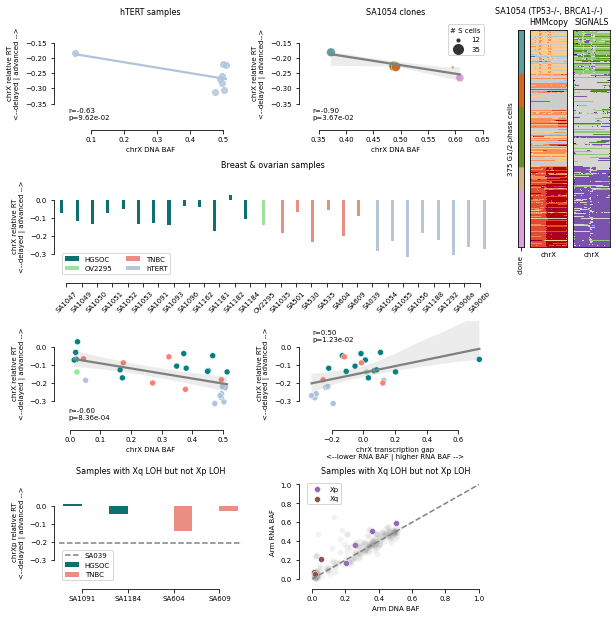

In [11]:
mult_factor = 1.0
fig = plt.figure(figsize=(8.5/mult_factor, 8.5/mult_factor))

# add three colorbars in the top-left corner to indicate which cells belong to which cell line, clone and time
ax0 = fig.add_axes([0.1, 0.8, 0.3, 0.17])
# ax0.set_title('ax0')
ax1 = fig.add_axes([0.5, 0.8, 0.3, 0.17], sharey=ax0)
# ax1.set_title('ax1')

# add three tall colorbars which contain the clone IDs, HMMcopy, and signals states for SA1054 G1/2-phase cells
ax2 = fig.add_axes([0.85, 0.6, 0.01, 0.355])
# ax2.set_title('ax2')
ax3 = fig.add_axes([0.87, 0.6, 0.06, 0.355])
# ax3.set_title('ax3')
ax4 = fig.add_axes([0.94, 0.6, 0.06, 0.355])
# ax4.set_title('ax4')

# add a subplot underneath ax0 and ax1 that spans the full width
ax5 = fig.add_axes([0.1, 0.55, 0.7, 0.17])
# ax5.set_title('ax5')

# add a 4x4 grid of results at the bottom
ax6 = fig.add_axes([0.1, 0.31, 0.3, 0.17], sharey=ax5)
# ax6.set_title('ax6')
ax7 = fig.add_axes([0.5, 0.31, 0.3, 0.17], sharey=ax5)
# ax7.set_title('ax7')
ax8 = fig.add_axes([0.1, 0.05, 0.3, 0.17], sharey=ax5)
# ax8.set_title('ax8')
ax9 = fig.add_axes([0.5, 0.05, 0.3, 0.17])
# ax9.set_title('ax9')

# the top left plot is the chrX relative RT vs DNA BAF for all hTERT sample pseudobulks
plot_hTERT_sample_bafs_vs_rt(sample_df, ax0)

# the top right plot is the SA1054 clone relative RT vs DNA BAF
plot_SA1054_subclonal_bafs_vs_rt(clone_df, ax1)

# create a barplot of all the sample relative RTs, sorted and colored by type
plot_sample_rt_delays(sample_df, ax5)

# the left plot in the 3rd row represents the chrX relative RT vs DNA BAF for all samples in the cohort
plot_all_sample_bafs_vs_rt(sample_df, ax6)

# the right plot in the 3rd row represents the chrX relative RT vs chrX transcription gap for all samples in the cohort
plot_transcription_gap_vs_rt(sample_df, ax7)

# the bottom left plot represents the Xp relative RT of samples with Xq LOH but balanced Xp
Xq_loh_samples = ['SA1091', 'SA1184', 'SA604', 'SA609']
plot_Xq_loh_rt_delays(sample_df, ax8, Xq_loh_samples)

# the bottom right plot shows the DNA BAF vs RNA BAF for samples with Xq LOH but balanced Xp
plot_Xq_loh_bafs(sample_df, sample_bafs, ax9, Xq_loh_samples)

# plot the hmmcopy and signals heatmaps for SA1054 G1/2-phase cells
plot_data = plot_cn_and_signals_states(
    df_SA1054, ax3, ax4, ax2,
    cn_col='state', signals_col='state_phase_int', secondary_sort_col='cell_id_int',
    clone_col='clone_id', chromosome='X'
)
ax3.set_title('SA1054 (TP53-/-, BRCA1-/-)\nHMMcopy')
ax4.set_title('SIGNALS')
ax3.set_xlabel('chrX')
ax4.set_xlabel('chrX')
ax2.set_ylabel('{} G1/2-phase cells'.format(df_SA1054.cell_id.nunique()))

# draw a dashed lines around the boundaries of the entire figure to know where to crop
# ax_bottom = fig.add_axes([0, 0, 1, 0.01])
# ax_top = fig.add_axes([0, 0.99, 1, 0.01])
# ax_left = fig.add_axes([0, 0, 0.01, 1])
# ax_right = fig.add_axes([0.99, 0, 0.01, 1])
# for ax in [ax_bottom, ax_top, ax_left, ax_right]:
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])

fig.savefig('scdna_replication_paper/plots/chrX/main_figure.pdf')

plt.show()